# Predicting House Sale Prices

In this project we will be attempting to model house prices using housing data for the city of Ames, Iowa, between the years of 2006 and 2010. This data collection was based around [this](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627) published paper. Further information on the data columns is available [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

In [29]:
# importing all necessary python modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import KFold

In [2]:
ames = pd.read_csv('AmesHousing.tsv', sep='\t')

With the data read-in, we can start by building the pipeline we want to use. We will use three steps:

1. Transform the features into usable data
2. Select the relevant features
3. Build the model and test accuracy

In [3]:
def transform_features(df):
    return df

In [4]:
def select_features(df):
    feature_cols = ['Gr Liv Area', 'SalePrice']
    return df[feature_cols]

In [5]:
def train_and_test(df):
    train = df.iloc[:1460]
    test = df.iloc[1460:]
    
    # seperate out the numerical data
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    
    features = numeric_train.columns.drop('SalePrice')
    target = 'SalePrice'
    
    # build and execute model
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train[target])
    prediction = lr.predict(test[features])
    
    # test model accuracy
    mse = mean_squared_error(test[target], prediction)
    rmse = np.sqrt(mse)
    return rmse

In [6]:
ames_transform = transform_features(ames)
ames_features = select_features(ames_transform)
ames_rmse = train_and_test(ames_features)
print('The RMSE for this model is {:.2f}'.format(ames_rmse))

The RMSE for this model is 57088.25


## Feature engineering

Let's now start removing features with many missing values, diving deeper into potential categorical features, and transforming text and numerical columns. The goal here is threefold:

1. Remove features that we don't want to use in the model, just based on the number of missing values or data leakage
2. Transform features into the proper format (numerical to categorical, scaling numerical, filling in missing values, etc)
3. Create new features by combining other features

Starting with missing values...

In [7]:
missing = ames.isnull().sum().sort_values(ascending=False)

In [8]:
# remove cols with over 5% of missing data
total_vals = ames.shape[0]
remove_cols = missing[missing/total_vals > 0.05]
remove_cols

Pool QC          2917
Misc Feature     2824
Alley            2732
Fence            2358
Fireplace Qu     1422
Lot Frontage      490
Garage Qual       159
Garage Yr Blt     159
Garage Cond       159
Garage Finish     159
Garage Type       157
dtype: int64

In [9]:
keep_cols = ames.columns.drop(remove_cols.index)
ames_full = ames[keep_cols]
print('{} columns are left, after dropping the {} with over 5% of missing data'.format(ames_full.shape[1], ames.shape[1]-ames_full.shape[1]))

71 columns are left, after dropping the 11 with over 5% of missing data


In [10]:
# seperate out numerical data
ames_num = ames_full.select_dtypes(include=['int', 'float'])
ames_txt = ames_full.drop(ames_num.columns, axis=1)
print('{} textual columns'.format(ames_txt.shape[1]))
print('{} numerical columns'.format(ames_num.shape[1]))

34 textual columns
37 numerical columns


In [11]:
# top 5 numerical columns with most missing values
ames_num.isnull().sum().sort_values(ascending=False).head()

Mas Vnr Area      23
Bsmt Half Bath     2
Bsmt Full Bath     2
Garage Cars        1
BsmtFin SF 1       1
dtype: int64

In [12]:
# replace missing values with Mode
ames_num = ames_num.fillna(value=ames_num.mode().iloc[0])
ames_num.isnull().sum().value_counts()

0    37
dtype: int64

In [13]:
# missing textual values
missing_txt = ames_txt.isnull().sum().sort_values(ascending=False).head(7)
missing_txt

Bsmt Exposure     83
BsmtFin Type 2    81
BsmtFin Type 1    80
Bsmt Qual         80
Bsmt Cond         80
Mas Vnr Type      23
Electrical         1
dtype: int64

In [14]:
# drop textual columns with missing values
ames_txt = ames_txt.drop(missing_txt.index, axis=1)
ames_txt.isnull().sum().value_counts()

0    27
dtype: int64

Now that we have dealt with missing values, we can create more meaningful features with the data we have. 

In [15]:
# year colums converted to year differences
ames_num['years_sold'] = ames_num['Yr Sold'] - ames_num['Year Built']
ames_num['years_since_remod'] = ames_num['Yr Sold'] - ames_num['Year Remod/Add']

# remove negative values
pos_years = (ames_num['years_sold'] > 0) & (ames_num['years_since_remod'] > 0)
ames_num = ames_num[pos_years]

# remove old year columns
ames_num = ames_num.drop(['Year Built', 'Year Remod/Add', 'Yr Sold'], axis = 1)

Finally, we can drop any other columns which come under the two categories:

1. Not usefuly for our machine learning model
2. Leaking data about the final sale

In [16]:
# drop columns that aren't useful for ML
ames_num = ames_num.drop(['PID', 'Order'], axis=1)

# drop columns that leak info about the final sale
ames_num = ames_num.drop(['Mo Sold'], axis=1)
ames_txt = ames_txt.drop(['Sale Condition', 'Sale Type'], axis=1)

print(ames_num.shape)
print(ames_txt.shape)

(2689, 33)
(2930, 25)


We can now integrate all of these methods into the transform features function from before.

In [17]:
def transform_features(df):
    # remove cols with over 5% missing
    missing = df.isnull().sum().sort_values(ascending=False)
    keep_cols = missing[missing/df.shape[0] < 0.05]
    df = df[keep_cols.index]

    # remove text cols with any missing data
    missing_txt = df.select_dtypes(include=['object']).isnull().sum()
    df = df.drop(missing_txt[missing_txt > 0].index, axis=1)

    # fill in missing numerical with most common value
    df_num = df.select_dtypes(include=['int', 'float'])
    df_num = df_num.fillna(value=df_num.mode().iloc[0])
    df[df_num.columns] = df_num

    # year difference columns
    df['years_sold'] = df['Yr Sold'] - df['Year Built']
    df['years_since_remod'] = df['Yr Sold'] - df['Year Remod/Add']
    pos_years = (df['years_sold'] > 0) & (df['years_since_remod'] > 0)
    df = df[pos_years]
    df = df.drop(['Year Built', 'Year Remod/Add', 'Yr Sold'], axis = 1)
    
    # drop other unnecessary columns
    df = df.drop(['PID', 'Order', 'Mo Sold', 'Sale Condition', 'Sale Type'], axis=1)
    return df

In [18]:
transform_ames = transform_features(ames)
filtered_ames = select_features(transform_ames)
ames_rmse = train_and_test(filtered_ames)
print('The RMSE for this model is {:.2f}'.format(ames_rmse))

The RMSE for this model is 47125.95


By going through some of these feature engineering steps we managed to reduce the RMSE of our model from ~57k to ~47k, which is a relatively significant change. 

## Feature selection

Now that we have cleaned and transformed a lot of the features in the data set, it's time to move on to feature selection for numerical features.

In [19]:
df_num = transform_ames.select_dtypes(include=['int', 'float'])
corrmat = df_num.corr()
sorted_corrs = corrmat['SalePrice'].abs().sort_values(ascending=False)
key_corrs = sorted_corrs[sorted_corrs > 0.4]

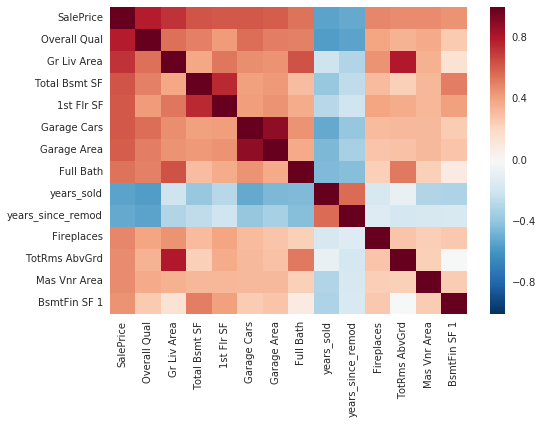

In [20]:
corrmat = df_num[key_corrs.index].corr()
sns.heatmap(corrmat)
plt.show()

In [21]:
drop_corrs = sorted_corrs[sorted_corrs < 0.4]
transform_ames = transform_ames.drop(drop_corrs.index, axis=1)

We will now look at converting categorical data into a more useful form. From the data documentation the following columns have been identified. Many of these may have been removed throughout the initial stages, so they first need to be checked if still present.

In [25]:
cat_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
cat_cols = []
for col in cat_features:
    if col in transform_ames:
        cat_cols.append(col)
        
# unique values in each categorical column
unique_count = transform_ames[cat_cols].apply(lambda col: len(col.value_counts())).sort_values(ascending=False)
unique_count

Condition 1     9
House Style     8
Condition 2     8
Roof Matl       7
MS Zoning       7
Heating         6
Foundation      6
Roof Style      6
Bldg Type       5
Lot Config      5
Land Contour    4
Central Air     2
Street          2
dtype: int64

As we can see, the maximum number of unique values in all the remaining categorical columns is 9. This should not be too many to add back into the main dataframe when converted to columns, so we can proceed with all 13.

In [26]:
remaining_cats = unique_count.index
for col in remaining_cats:
    transform_ames[col] = transform_ames[col].astype('category')
    
# create dummy columns and add back to the main dataframe
transform_ames = pd.concat([
    transform_ames, 
    pd.get_dummies(transform_ames.select_dtypes(include=['category']))
], axis=1).drop(remaining_cats, axis=1)

With this categorical data converted and pushed back into the main dataframe, a potential further step may be to explore how these columns correlate with our target SalePrice. For now we will re-build our select_features function, and continue on. 

In [27]:
def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    numerical_df = df.select_dtypes(include=['int', 'float'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis=1)
    
    cat_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    cat_cols = []
    for col in cat_features:
        if col in df.columns:
            cat_cols.append(col)

    uniq_counts = df[cat_cols].apply(lambda col: len(col.value_counts()))
    uniq_cols = uniq_counts[uniq_counts > uniq_threshold].index
    df = df.drop(uniq_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)
    
    return df

In [28]:
transform_ames = transform_features(ames)
filtered_ames = select_features(transform_ames)
ames_rmse = train_and_test(filtered_ames)
print('The RMSE for this model is {:.2f}'.format(ames_rmse))

The RMSE for this model is 26415.72


The feature selection had had a huge impact reducing the RMSE to almost half what it was after the feature engineering. We can now continue to the final step of Training and Testing. 

## Train & test

When iterating on different features, using simple validation is a good idea. We will attempt to implement a cross-validation method to verify our results. 

In [30]:
def train_and_test(df, k=0):
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]

        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)

        return rmse
    
    if k == 1:
        # Randomize *all* rows (frac=1) from `df` and return
        shuffled_df = df.sample(frac=1, )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])        
        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])        
       
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        print(rmse_one)
        print(rmse_two)
        return avg_rmse
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse

In [33]:
ames_rmse = train_and_test(filtered_ames, k=4)
print('The average RMSE for this model is {:.2f}'.format(ames_rmse))

[23515.713533857303, 24950.3303927328, 22954.828464464113, 26980.781302215368]
The average RMSE for this model is 24600.41


## Next steps...

By running through some basic feature engineering and selection, we significantly improved our prediction results by lowering ouw error rate, and more thoroughly verified our results by implementing cross-validation. 

Here are some potential next steps:

- Continue iteration on feature engineering:
    - Research some other approaches to feature engineering online around housing data.
- Improve your feature selection:
    - Research ways of doing feature selection better with categorical columns.